# 4. Evaluation Statistic

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
import copy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import BernoulliNB as BNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix


In [2]:
Train = pd.read_csv('./Data/Train_Preprocessed.csv')
Future = pd.read_csv('./Data/Future_Preprocessed.csv')


def cleanAndSplit(df, mode):
    
    text_list = list()
    
    for tweet in df['text']:

        tmp = list()

        if mode == 'NoHashtag':
            tweet = re.sub(r'[^\w%\'-]', ' ', tweet)

            # get rid of non-english characters
            tweet = re.sub(r'[^\x00-\x7F ]+', ' ', tweet) 
        
        else:
        
            # get rid of non-alphanumerical chars, effectively splitting them
            # except for at ' - # and %
            tweet = re.sub(r'[^\x00-\x7F#%\'-]', ' ', tweet)


        # split the words based on space
        words = tweet.split()

        for word in words:

            # get rid of ' and % and - that are outside of words
            word = word.strip('\'%-')
            
            # gets rid of other noise
            if mode == 'NoHashtag':
                word = re.sub(r'[^-\w\']', '', word)
            
            else:
                word = re.sub(r'[^\w#-\']', '', word)


            if word not in ['', '#']:
                tmp.append(word)
                
        text_list.append(tmp)
    
    return text_list
   

In [3]:
     
def join_string(text):
    return ' '.join(text)

TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')

FutureWords = Future.copy(deep=True)
FutureWords['text'] = cleanAndSplit(Future, 'Hashtag')

In [4]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stem_text(text):
    return [ps.stem(w) for w in text]
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return [w for w in text if not w in stop_words]

Y_PreproTFIDF = TrainWords['sentiment'] # because drop one duplicate 


X_train, X_valtest, y_train, y_valtest = train_test_split(TrainWords, Y_PreproTFIDF, train_size = 0.7, random_state = 30027)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)

In [5]:
## Preprocess TFIDF
# Train
TrainPreproTFIDF = X_train.copy(deep = True)
TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
Train_PreproTFIDF = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


ValPreproTFIDF = X_val.copy(deep = True)
ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
Val_PreproTFIDF = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

TestPreproTFIDF = X_test.copy(deep = True)
TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
Test_Prepro_TFIDF = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])


# Future
FuturePreproTFIDF = FutureWords.copy(deep = True)
FuturePreproTFIDF['text'] = FuturePreproTFIDF['text'].apply(stem_text)
FuturePreproTFIDF['text'] = FuturePreproTFIDF['text'].apply(join_string)
X_Future_PreproTFIDF = tfidf_vectorizer_Prepro.transform(FuturePreproTFIDF['text'])



# ##UNPROCESSED only TFIDF
# # Train
# TrainTFIDF = pd.read_csv("./Data/Train.csv")

# Y_TFIDF = TrainTFIDF['sentiment']

# tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
# X_TrainTFIDF = tfidf_vectorizer.fit_transform(TrainTFIDF['text'])

# # Future
# FutureTFIDF = pd.read_csv("./Data/Future.csv")
# X_Future_TFIDF = tfidf_vectorizer.transform(FutureTFIDF['text'])



# ##UNPROCESSED TFIDF + rid junk
# # Train
# TrainNoJunkTFIDF = TrainTFIDF.copy(deep = True)
# TrainNoJunkTFIDF['text'] = cleanAndSplit(TrainNoJunkTFIDF, 'Hashtag')
# tfidf_vectorizer_NoJunk = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
# TrainNoJunkTFIDF['text'] = TrainNoJunkTFIDF['text'].apply(join_string)
# X_TrainNoJunkTFIDF = tfidf_vectorizer_NoJunk.fit_transform(TrainNoJunkTFIDF['text'])


# # Future
# FutureNoJunkTFIDF = FutureTFIDF.copy(deep = True)
# FutureNoJunkTFIDF['text'] = cleanAndSplit(FutureNoJunkTFIDF, 'Hashtag')
# FutureNoJunkTFIDF['text'] = FutureNoJunkTFIDF['text'].apply(join_string)
# X_Future_NoJunkTFIDF = tfidf_vectorizer_NoJunk.transform(FutureNoJunkTFIDF['text'])




# # W2V
# TrainW2V = pd.read_csv('./Data/W300V_Train.csv')

# FutureW2V = pd.read_csv('./Data/W300V_Future.csv')

X_train_ = copy.deepcopy(Train_PreproTFIDF) # 有preprocess，TFIDF
X_val_ = copy.deepcopy(Val_PreproTFIDF)
X_test_ = copy.deepcopy(Test_Prepro_TFIDF)
# Y_ = copy.deepcopy(Y_PreproTFIDF) # 1 用

X_Future_ = copy.deepcopy(X_Future_PreproTFIDF)

In [6]:
# def evaluate(y_test, y_pred):
#     eval_ = pd.DataFrame({'p': y_pred, 't': y_test})
    
#     y_test = list(y_test)
    
#     n = len(y_test)
#     n1 = sum([1 for i in range(len(y_test)) if y_test[i] == 'positive'])
#     n2 = sum([1 for i in range(len(y_test)) if y_test[i] == 'neutral'])
#     n3 = sum([1 for i in range(len(y_test)) if y_test[i] == 'negative'])
    
#     predPosd = [ len(eval_[(eval_['p'] == 'positive') & (eval_['t'] == 'positive')])/n,
#                len(eval_[(eval_['p'] == 'positive') & (eval_['t'] == 'neutral')])/n,
#                len(eval_[(eval_['p'] == 'positive') & (eval_['t'] == 'negative')])/n
#               ]
#     predNeud = [ len(eval_[(eval_['p'] == 'neutral') & (eval_['t'] == 'positive')])/n,
#                len(eval_[(eval_['p'] == 'neutral') & (eval_['t'] == 'neutral')])/n,
#                len(eval_[(eval_['p'] == 'neutral') & (eval_['t'] == 'negative')])/n
#               ]
#     predNegd = [ len(eval_[(eval_['p'] == 'negative') & (eval_['t'] == 'positive')])/n,
#                len(eval_[(eval_['p'] == 'negative') & (eval_['t'] == 'neutral')])/n,
#                len(eval_[(eval_['p'] == 'negative') & (eval_['t'] == 'negative')])/n
#               ]
    
#     predPos = [ len(eval_[(eval_['p'] == 'positive') & (eval_['t'] == 'positive')]),
#                len(eval_[(eval_['p'] == 'positive') & (eval_['t'] == 'neutral')]),
#                len(eval_[(eval_['p'] == 'positive') & (eval_['t'] == 'negative')])
#               ]
#     predNeu = [ len(eval_[(eval_['p'] == 'neutral') & (eval_['t'] == 'positive')]),
#                len(eval_[(eval_['p'] == 'neutral') & (eval_['t'] == 'neutral')]),
#                len(eval_[(eval_['p'] == 'neutral') & (eval_['t'] == 'negative')])
#               ]
#     predNeg = [ len(eval_[(eval_['p'] == 'negative') & (eval_['t'] == 'positive')]),
#                len(eval_[(eval_['p'] == 'negative') & (eval_['t'] == 'neutral')]),
#                len(eval_[(eval_['p'] == 'negative') & (eval_['t'] == 'negative')])
#               ]
    
#     accuracy = predPos[0] + predNeu[1] + predNeg[2]
    
#     error_rate = 1-accuracy
    
#     confus_matrix = pd.DataFrame({'predPos': predPos, 'predNeu': predNeu, 'predNeg': predNeg}, 
#                                  index = ['truePos', 'trueNeu', 'trueNeg'])
#     confus_matrix_d = pd.DataFrame({'predPos': predPosd, 'predNeu': predNeud, 'predNeg': predNegd}, 
#                                  index = ['truePos', 'trueNeu', 'trueNeg'])
    
#     # error_reduction_rate = error_rate - 
    
#     precision1 = 0 if (sum(predPos)) == 0 else predPos[0]/(sum(predPos))
#     precision2 = 0 if (sum(predNeu)) == 0 else predNeu[1]/(sum(predNeu))
#     precision3 = 0 if (sum(predNeg)) == 0 else predNeg[2]/(sum(predNeg))
    
#     recall1 = 0 if (predPos[0]+predNeu[0]+predNeg[0]) == 0 else predPos[0]/(predPos[0]+predNeu[0]+predNeg[0])
#     recall2 = 0 if (predPos[1]+predNeu[1]+predNeg[1]) == 0 else predNeu[1]/(predPos[1]+predNeu[1]+predNeg[1])
#     recall3 = 0 if (predPos[2]+predNeu[2]+predNeg[2]) == 0 else predNeg[2]/(predPos[2]+predNeu[2]+predNeg[2])
    
#     f11 = 0 if (precision1+recall1) == 0 else (2*precision1*recall1)/(precision1+recall1)
#     f12 = 0 if (precision2+recall2) == 0 else (2*precision2*recall2)/(precision2+recall2)
#     f13 = 0 if (precision3+recall3) == 0 else (2*precision3*recall3)/(precision3+recall3)
    
#     # specificity1 = 
#     # specificity2 = 
#     # specificity3 = 
    
#     col1 = [precision1, recall1, f11]
#     col2 = [precision2, recall2, f12]
#     col3 = [precision3, recall3, f13]
    
#     precision = (n1/n)*precision1 + (n2/n)*precision2 + (n3/n)*precision3
#     recall = (n1/n)*recall1 + (n2/n)*recall2 + (n3/n)*recall3
#     f1 = (n1/n)*f11 + (n2/n)*f12 + (n3/n)*f13
    
#     scores = pd.DataFrame({'Pos': col1, 'Neu': col2, 'Neg': col3}, index = ['precision', 'recall', 'f1'])
    
#     return confus_matrix, confus_matrix_d, scores, accuracy/n, precision, recall, f1

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import time

# 0R model

training accuracy:  0.5806155602453147
validation accuracy:  0.580091743119266
testing accuracy:  0.5811380605647607
weighted precision is 0.34152764918777884
weighted recall is 0.5844036697247706
weighted f1_score is 0.4311119138560265


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


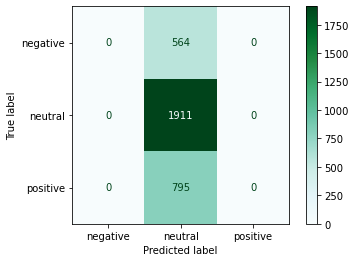

In [8]:
Train_0R = pd.read_csv('./Data/Train.csv')


ZeroR = DummyClassifier(strategy = "most_frequent")
# X_train, X_valtest, y_train, y_valtest = train_test_split(X_0R, y_0R, train_size = 0.7, random_state = 30027)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)
ZeroR.fit(X_train, y_train)


Train = pd.read_csv('./Data/Train_Preprocessed.csv')

kf = KFold(n_splits=5, shuffle=True, random_state=30027)
TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')
train_acc_score = []
val_acc_score = []
test_acc_score = []
for train_index, valtest_index in kf.split(Train):
    val_index, test_index = train_test_split(valtest_index, train_size = 0.5, random_state = 30027)
    
    tmp_y_train = Train['sentiment'][train_index] 
    tmp_y_val = Train['sentiment'][val_index]
    tmp_y_test = Train['sentiment'][test_index]
    
    tmp_train = TrainWords.loc[train_index]
    tmp_val = TrainWords.loc[val_index]
    tmp_test = TrainWords.loc[test_index]
    
    TrainPreproTFIDF = tmp_train.copy(deep = True)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
    tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
    tmp_train = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


    ValPreproTFIDF = tmp_val.copy(deep = True)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
    tmp_val = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

    TestPreproTFIDF = tmp_test.copy(deep = True)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
    tmp_test = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])
    
    ZeroR1 = DummyClassifier(strategy = "most_frequent")
    ZeroR1.fit(tmp_train, tmp_y_train)
    
    train_acc_score.append(accuracy_score(tmp_y_train, ZeroR1.predict(tmp_train)))
    val_acc_score.append(accuracy_score(tmp_y_val, ZeroR1.predict(tmp_val)))
    test_acc_score.append(accuracy_score(tmp_y_test, ZeroR1.predict(tmp_test)))

print('training accuracy: ', sum(train_acc_score)/5)
print('validation accuracy: ', sum(val_acc_score)/5)
print('testing accuracy: ', sum(test_acc_score)/5)

# zeroR_train_acc = np.mean(cross_val_score(ZeroR, X_train, y_train, cv=5))
# print("training accuracy is", zeroR_train_acc)


# zeroR_val_acc = np.mean(cross_val_score(ZeroR, X_val, y_val, cv=5))
# print("validation accuracy is", zeroR_val_acc)


# zeroR_test_acc = np.mean(cross_val_score(ZeroR, X_test, y_test, cv=5))
# print("testing accuracy is", zeroR_test_acc)



ZeroR_predofval = ZeroR.predict(X_val)
weighted_precision = precision_score(y_val, ZeroR_predofval, average = "weighted")
weighted_recall= recall_score(y_val, ZeroR_predofval, average = "weighted")
weighted_f1 = f1_score(y_val, ZeroR_predofval, average = "weighted")
print("weighted precision is", weighted_precision)
print("weighted recall is", weighted_recall)
print("weighted f1_score is", weighted_f1)

plot_confusion_matrix(ZeroR, X_val, y_val, cmap = 'BuGn')

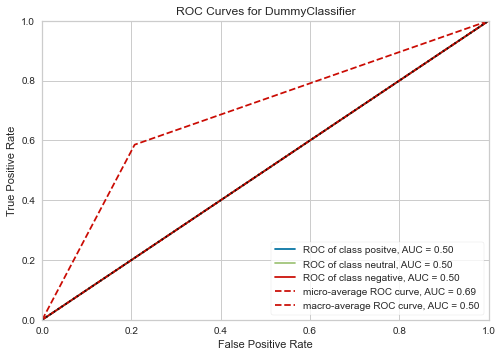

<AxesSubplot:title={'center':'ROC Curves for DummyClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


from yellowbrick.classifier import ROCAUC



# Creating visualization with the readable labels
visualizerLG = ROCAUC(ZeroR, classes=["positve", "neutral", "negative"])

# Fitting to the training data first then scoring with the test data                                    
visualizerLG.fit(X_train, y_train)
visualizerLG.score(X_test, y_test)
visualizerLG.show()

# Logistic Regression

weighted precision is 0.6647444291063709
weighted recall is 0.671559633027523
weighted f1_score is 0.6534242830148109
training accuracy:  0.7297256852591884
validation accuracy:  0.6687155963302752
testing accuracy:  0.6801195058238582
fitting time is 31.8414568901062s


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


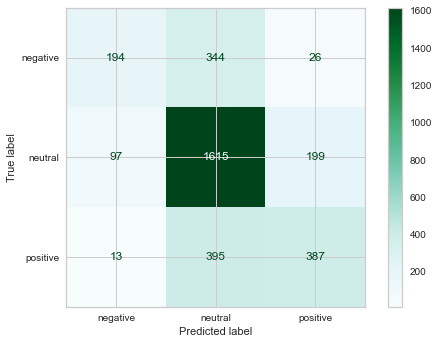

In [10]:
lgr = LogisticRegression(max_iter = 5000, penalty = 'l1', solver = 'saga', C = 2, multi_class = 'ovr')
# X_train, X_valtest, y_train, y_valtest = train_test_split(X_, Y_, train_size = 0.7, random_state = 30027)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)

X_train = copy.deepcopy(X_train_)
X_val = copy.deepcopy(X_val_)
X_test = copy.deepcopy(X_test_)

X2 = SelectKBest(chi2, k=int(X_train.shape[1]*0.25)+5000)
X2.fit(X_train, y_train)

X_train = X2.transform(X_train)
X_val = X2.transform(X_val)
X_test = X2.transform(X_test)

t0 = time.time()
lgr.fit(X_train, y_train)
t1 = time.time() - t0

lgr_predofval = lgr.predict(X_val)
weighted_precision = precision_score(y_val, lgr_predofval, average = "weighted")
weighted_recall= recall_score(y_val, lgr_predofval, average = "weighted")
weighted_f1 = f1_score(y_val, lgr_predofval, average = "weighted")
print("weighted precision is", weighted_precision)
print("weighted recall is", weighted_recall)
print("weighted f1_score is", weighted_f1)


Train = pd.read_csv('./Data/Train_Preprocessed.csv')

kf = KFold(n_splits=5, shuffle=True, random_state=30027)
TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')
train_acc_score = []
val_acc_score = []
test_acc_score = []
for train_index, valtest_index in kf.split(Train):
    val_index, test_index = train_test_split(valtest_index, train_size = 0.5, random_state = 30027)
    
    tmp_y_train = Train['sentiment'][train_index] 
    tmp_y_val = Train['sentiment'][val_index]
    tmp_y_test = Train['sentiment'][test_index]
    
    tmp_train = TrainWords.loc[train_index]
    tmp_val = TrainWords.loc[val_index]
    tmp_test = TrainWords.loc[test_index]
    
    TrainPreproTFIDF = tmp_train.copy(deep = True)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
    tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
    tmp_train = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


    ValPreproTFIDF = tmp_val.copy(deep = True)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
    tmp_val = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

    TestPreproTFIDF = tmp_test.copy(deep = True)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
    tmp_test = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])
    
    lgr1 = LogisticRegression(max_iter = 5000, penalty = 'l1', solver = 'saga', C = 2, multi_class = 'ovr')
    
    X2_ = SelectKBest(chi2, k=int(X_train.shape[1]*0.25))
    X2_.fit(tmp_train, tmp_y_train)
    tmp_train = X2_.transform(tmp_train)
    tmp_val = X2_.transform(tmp_val)
    tmp_test = X2_.transform(tmp_test)
    
    lgr1.fit(tmp_train, tmp_y_train)
    
    train_acc_score.append(accuracy_score(tmp_y_train, lgr1.predict(tmp_train)))
    val_acc_score.append(accuracy_score(tmp_y_val, lgr1.predict(tmp_val)))
    test_acc_score.append(accuracy_score(tmp_y_test, lgr1.predict(tmp_test)))

print('training accuracy: ', sum(train_acc_score)/5)
print('validation accuracy: ', sum(val_acc_score)/5)
print('testing accuracy: ', sum(test_acc_score)/5)

# lgr_train_acc = np.mean(cross_val_score(lgr, X_train, y_train, cv=5))
# print("training accuracy is", lgr_train_acc)


# lgr_val_acc = np.mean(cross_val_score(lgr, X_val, y_val, cv=5))
# print("validation accuracy is", lgr_val_acc)


# lgr_test_acc = np.mean(cross_val_score(lgr, X_test, y_test, cv=5))
# print("testing accuracy is", lgr_test_acc)

print(f"fitting time is {t1}s")

plot_confusion_matrix(lgr, X_val, y_val, cmap = 'BuGn')

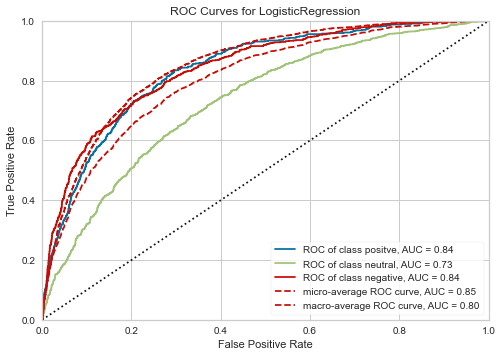

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [11]:
# Creating visualization with the readable labels
visualizerLG = ROCAUC(lgr, classes=["positve", "neutral", "negative"])

# Fitting to the training data first then scoring with the test data                                    
visualizerLG.fit(X_train, y_train)
visualizerLG.score(X_test, y_test)
visualizerLG.show()

In [12]:
X_Future = copy.deepcopy(X_Future_)
X_Future = X2.transform(X_Future)
lgr_pred = lgr.predict(X_Future)

In [13]:
lgr_out = copy.deepcopy(Future)
lgr_out = lgr_out.drop(['text'], axis = 1)
lgr_out['sentiment'] = lgr_pred

lgr_out.to_csv('./Predictions/lgr.csv', index = False)

# Random Forest

weighted precision is 0.6506176177282014
weighted recall is 0.6149847094801223
weighted f1_score is 0.5216495683951603
training accuracy:  0.6334112958288205
validation accuracy:  0.6122935779816514
testing accuracy:  0.6190245615806234
fitting time is 0.9177930355072021s


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


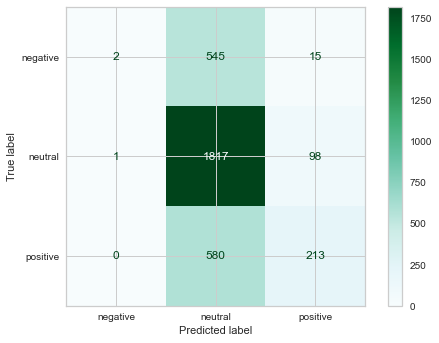

In [14]:
RF = RandomForestClassifier(criterion = 'gini', n_estimators = 50, max_depth = 10, max_features = 0.5, max_samples = 0.25)
# X_train, X_valtest, y_train, y_valtest = train_test_split(X_, Y_, train_size = 0.7, random_state = 30027)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)
X_train = copy.deepcopy(X_train_)
X_val = copy.deepcopy(X_val_)
X_test = copy.deepcopy(X_test_)

X2 = SelectKBest(chi2, k=int(X_train.shape[1]*0.25))
X2.fit(X_train, y_train)
X_train = X2.transform(X_train)
X_val = X2.transform(X_val)
X_test = X2.transform(X_test)
t0 = time.time()
RF.fit(X_train, y_train)
t1 = time.time() - t0


RF_predofval = RF.predict(X_val)
weighted_precision = precision_score(y_val, RF_predofval, average = "weighted")
weighted_recall= recall_score(y_val, RF_predofval, average = "weighted")
weighted_f1 = f1_score(y_val, RF_predofval, average = "weighted")
print("weighted precision is", weighted_precision)
print("weighted recall is", weighted_recall)
print("weighted f1_score is", weighted_f1)


Train = pd.read_csv('./Data/Train_Preprocessed.csv')

kf = KFold(n_splits=5, shuffle=True, random_state=30027)
TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')
train_acc_score = []
val_acc_score = []
test_acc_score = []
for train_index, valtest_index in kf.split(Train):
    val_index, test_index = train_test_split(valtest_index, train_size = 0.5, random_state = 30027)
    
    tmp_y_train = Train['sentiment'][train_index] 
    tmp_y_val = Train['sentiment'][val_index]
    tmp_y_test = Train['sentiment'][test_index]
    
    tmp_train = TrainWords.loc[train_index]
    tmp_val = TrainWords.loc[val_index]
    tmp_test = TrainWords.loc[test_index]
    
    TrainPreproTFIDF = tmp_train.copy(deep = True)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
    tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
    tmp_train = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


    ValPreproTFIDF = tmp_val.copy(deep = True)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
    tmp_val = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

    TestPreproTFIDF = tmp_test.copy(deep = True)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
    tmp_test = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])
    
    RF1 = RandomForestClassifier(criterion = 'gini', n_estimators = 50, max_depth = 10, max_features = 0.5, max_samples = 0.25)
    
    X2_ = SelectKBest(chi2, k=int(X_train.shape[1]*0.25))
    X2_.fit(tmp_train, tmp_y_train)
    tmp_train = X2_.transform(tmp_train)
    tmp_val = X2_.transform(tmp_val)
    tmp_test = X2_.transform(tmp_test)
    
    RF1.fit(tmp_train, tmp_y_train)
    
    train_acc_score.append(accuracy_score(tmp_y_train, RF1.predict(tmp_train)))
    val_acc_score.append(accuracy_score(tmp_y_val, RF1.predict(tmp_val)))
    test_acc_score.append(accuracy_score(tmp_y_test, RF1.predict(tmp_test)))

print('training accuracy: ', sum(train_acc_score)/5)
print('validation accuracy: ', sum(val_acc_score)/5)
print('testing accuracy: ', sum(test_acc_score)/5)


# RF_train_acc = np.mean(cross_val_score(RF, X_train, y_train, cv=5))
# print("training accuracy is", RF_train_acc)


# RF_val_acc = np.mean(cross_val_score(RF, X_val, y_val, cv=5))
# print("validation accuracy is", RF_val_acc)


# RF_test_acc = np.mean(cross_val_score(RF, X_test, y_test, cv=5))
# print("testing accuracy is", RF_test_acc)

print(f"fitting time is {t1}s")

plot_confusion_matrix(RF, X_test, y_test, cmap = 'BuGn')

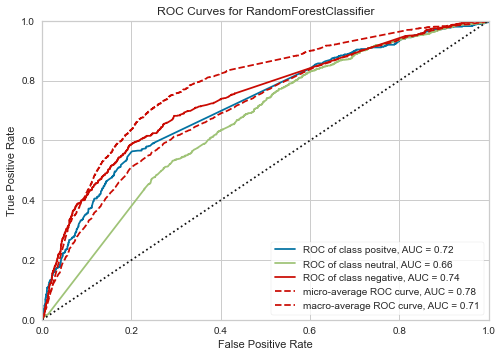

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [15]:
# Creating visualization with the readable labels
visualizerRF = ROCAUC(RF, classes=["positve", "neutral", "negative"])

# Fitting to the training data first then scoring with the test data                                    
visualizerRF.fit(X_train, y_train)
visualizerRF.score(X_test, y_test)
visualizerRF.show()

In [16]:
X_Future = copy.deepcopy(X_Future_)
X_Future = X2.transform(X_Future)
RF_pred = RF.predict(X_Future)

In [17]:
RF_out = copy.deepcopy(Future)
RF_out = RF_out.drop(['text'], axis = 1)
RF_out['sentiment'] = RF_pred

RF_out.to_csv('./Predictions/RF.csv', index = False)

# SVM

weighted precision is 0.6527838879354956
weighted recall is 0.6599388379204894
weighted f1_score is 0.6348711168702154
training accuracy:  0.7265950887369159
validation accuracy:  0.6696330275229359
testing accuracy:  0.6769089172965856
fitting time is 21.82360291481018s


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


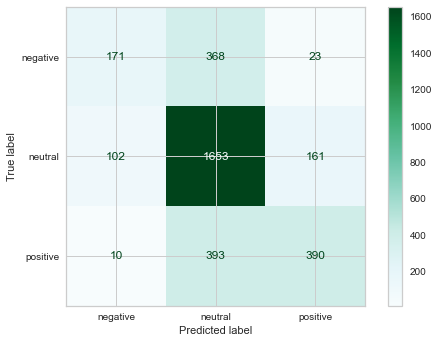

In [18]:
SVM = SVC(C = 10, decision_function_shape =  'ovo', degree = 1, gamma = 0.1, kernel = 'poly')
# X_train, X_valtest, y_train, y_valtest = train_test_split(X_, Y_, train_size = 0.7, random_state = 30027)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)
X_train = copy.deepcopy(X_train_)
X_val = copy.deepcopy(X_val_)
X_test = copy.deepcopy(X_test_)
t0 = time.time()
SVM.fit(X_train, y_train)
t1 = time.time() - t0

SVM_predofval = SVM.predict(X_val)
weighted_precision = precision_score(y_val, SVM_predofval, average = "weighted")
weighted_recall= recall_score(y_val, SVM_predofval, average = "weighted")
weighted_f1 = f1_score(y_val, SVM_predofval, average = "weighted")
print("weighted precision is", weighted_precision)
print("weighted recall is", weighted_recall)
print("weighted f1_score is", weighted_f1)


Train = pd.read_csv('./Data/Train_Preprocessed.csv')

kf = KFold(n_splits=5, shuffle=True, random_state=30027)
TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')
train_acc_score = []
val_acc_score = []
test_acc_score = []
for train_index, valtest_index in kf.split(Train):
    val_index, test_index = train_test_split(valtest_index, train_size = 0.5, random_state = 30027)
    
    tmp_y_train = Train['sentiment'][train_index] 
    tmp_y_val = Train['sentiment'][val_index]
    tmp_y_test = Train['sentiment'][test_index]
    
    tmp_train = TrainWords.loc[train_index]
    tmp_val = TrainWords.loc[val_index]
    tmp_test = TrainWords.loc[test_index]
    
    TrainPreproTFIDF = tmp_train.copy(deep = True)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
    tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
    tmp_train = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


    ValPreproTFIDF = tmp_val.copy(deep = True)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
    tmp_val = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

    TestPreproTFIDF = tmp_test.copy(deep = True)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
    tmp_test = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])
    
    SVM1 = SVC(C = 10, decision_function_shape =  'ovo', degree = 1, gamma = 0.1, kernel = 'poly')
    
    X2_ = SelectKBest(chi2, k=int(X_train.shape[1]*0.25))
    X2_.fit(tmp_train, tmp_y_train)
    tmp_train = X2_.transform(tmp_train)
    tmp_val = X2_.transform(tmp_val)
    tmp_test = X2_.transform(tmp_test)
    
    SVM1.fit(tmp_train, tmp_y_train)

    train_acc_score.append(accuracy_score(tmp_y_train, SVM1.predict(tmp_train)))
    val_acc_score.append(accuracy_score(tmp_y_val, SVM1.predict(tmp_val)))
    test_acc_score.append(accuracy_score(tmp_y_test, SVM1.predict(tmp_test)))

print('training accuracy: ', sum(train_acc_score)/5)
print('validation accuracy: ', sum(val_acc_score)/5)
print('testing accuracy: ', sum(test_acc_score)/5)

# SVM_train_acc = np.mean(cross_val_score(SVM, X_train, y_train, cv=5))
# print("training accuracy is", RF_train_acc)


# SVM_val_acc = np.mean(cross_val_score(SVM, X_val, y_val, cv=5))
# print("validation accuracy is", RF_val_acc)


# SVM_test_acc = np.mean(cross_val_score(SVM, X_test, y_test, cv=5))
# print("testing accuracy is", RF_test_acc)

print(f"fitting time is {t1}s")


plot_confusion_matrix(SVM, X_test, y_test, cmap = 'BuGn')

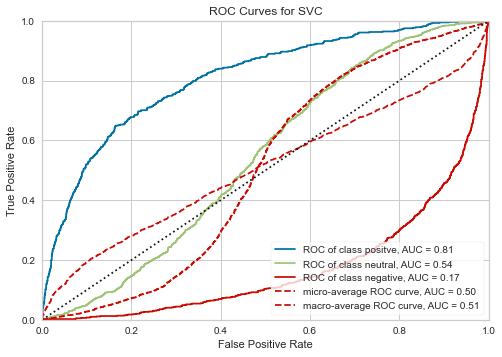

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
visualizerSVM = ROCAUC(SVM, classes=["positve", "neutral", "negative"])

# Fitting to the training data first then scoring with the test data                                    
visualizerSVM.fit(X_train, y_train)
visualizerSVM.score(X_test, y_test)
visualizerSVM.show()

In [20]:
X_Future = copy.deepcopy(X_Future_)
SVM_pred = SVM.predict(X_Future)

In [21]:
SVM_out = copy.deepcopy(Future)
SVM_out = SVM_out.drop(['text'], axis = 1)
SVM_out['sentiment'] = SVM_pred

SVM_out.to_csv('./Predictions/SVM.csv', index = False)

# XGB

training accuracy:  0.7418466649553488
validation accuracy:  0.6546788990825687
testing accuracy:  0.6603048849740671
fitting time is 1.8973181247711182s
weighted precision is 0.6462569638193019
weighted recall is 0.6522935779816513
weighted f1_score is 0.6159450715271932


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


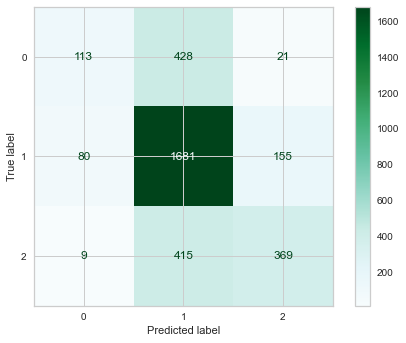

In [22]:
XGB = xgb.XGBClassifier(gamma = 1.0, subsample = 0.5, colsample_bytree = 0.5, max_depth = 6, eta = 0.25)
# X_train, X_valtest, y_train, y_valtest = train_test_split(X_, Y_, train_size = 0.7, random_state = 30027)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)
X_train = copy.deepcopy(X_train_)
X_val = copy.deepcopy(X_val_)
X_test = copy.deepcopy(X_test_)
y_train = y_train.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
y_val = y_val.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
y_test = y_test.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
X2 = SelectKBest(chi2, k=int(X_train.shape[1]*0.25)+4000)
X2.fit(X_train, y_train)
X_train = X2.transform(X_train)
X_val = X2.transform(X_val)
X_test = X2.transform(X_test)
t0 = time.time()
XGB.fit(X_train, y_train)
t1 = time.time() - t0


Train = pd.read_csv('./Data/Train_Preprocessed.csv')

kf = KFold(n_splits=5, shuffle=True, random_state=30027)
TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')
train_acc_score = []
val_acc_score = []
test_acc_score = []
for train_index, valtest_index in kf.split(Train):
    val_index, test_index = train_test_split(valtest_index, train_size = 0.5, random_state = 30027)
    
    tmp_y_train = Train['sentiment'][train_index] 
    tmp_y_val = Train['sentiment'][val_index]
    tmp_y_test = Train['sentiment'][test_index]
    
    tmp_y_train = tmp_y_train.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
    tmp_y_val = tmp_y_val.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
    tmp_y_test = tmp_y_test.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
    
    tmp_train = TrainWords.loc[train_index]
    tmp_val = TrainWords.loc[val_index]
    tmp_test = TrainWords.loc[test_index]
    
    TrainPreproTFIDF = tmp_train.copy(deep = True)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
    tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
    tmp_train = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


    ValPreproTFIDF = tmp_val.copy(deep = True)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
    tmp_val = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

    TestPreproTFIDF = tmp_test.copy(deep = True)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
    tmp_test = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])
    
    XGB1 = xgb.XGBClassifier(gamma = 1.0, subsample = 0.5, colsample_bytree = 0.5, max_depth = 6, eta = 0.25)
    
    X2_ = SelectKBest(chi2, k=int(X_train.shape[1]*0.25))
    X2_.fit(tmp_train, tmp_y_train)
    tmp_train = X2_.transform(tmp_train)
    tmp_val = X2_.transform(tmp_val)
    tmp_test = X2_.transform(tmp_test)
    
    XGB1.fit(tmp_train, tmp_y_train)

    train_acc_score.append(accuracy_score(tmp_y_train, XGB1.predict(tmp_train)))
    val_acc_score.append(accuracy_score(tmp_y_val, XGB1.predict(tmp_val)))
    test_acc_score.append(accuracy_score(tmp_y_test, XGB1.predict(tmp_test)))

print('training accuracy: ', sum(train_acc_score)/5)
print('validation accuracy: ', sum(val_acc_score)/5)
print('testing accuracy: ', sum(test_acc_score)/5)

print(f"fitting time is {t1}s")



XGB_predofval = XGB.predict(X_val)
weighted_precision = precision_score(y_val, XGB_predofval, average = "weighted")
weighted_recall= recall_score(y_val, XGB_predofval, average = "weighted")
weighted_f1 = f1_score(y_val, XGB_predofval, average = "weighted")
print("weighted precision is", weighted_precision)
print("weighted recall is", weighted_recall)
print("weighted f1_score is", weighted_f1)

# XGB_train_acc = np.mean(cross_val_score(XGB, X_train, y_train, cv=5))
# print("training accuracy is", XGB_train_acc)


# XGB_val_acc = np.mean(cross_val_score(XGB, X_val, y_val, cv=5))
# print("validation accuracy is", XGB_val_acc)


# XGB_test_acc = np.mean(cross_val_score(XGB, X_test, y_test, cv=5))
# print("testing accuracy is", XGB_test_acc)

plot_confusion_matrix(XGB, X_test, y_test, cmap = 'BuGn')

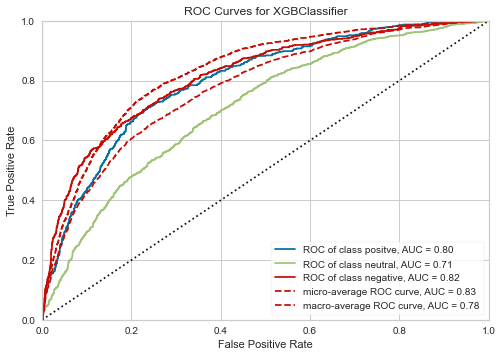

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [23]:
visualizerXGB = ROCAUC(XGB, classes=["positve", "neutral", "negative"])

# Fitting to the training data first then scoring with the test data                                    
visualizerXGB.fit(X_train, y_train)
visualizerXGB.score(X_test, y_test)
visualizerXGB.show()

In [24]:
X_Future = copy.deepcopy(X_Future_)
X_Future = X2.transform(X_Future)
XGB_pred = XGB.predict(X_Future)

In [25]:
XGB_out = copy.deepcopy(Future)
XGB_out = XGB_out.drop(['text'], axis = 1)
XGB_out['sentiment'] = XGB_pred
XGB_out['sentiment'] = XGB_out['sentiment'].replace([0, 1, 2], ['negative', 'neutral', 'positive'])

XGB_out.to_csv('./Predictions/XGB.csv', index = False)

# Stacker

training accuracy:  0.7415026282581011
validation accuracy:  0.6728440366972477
testing accuracy:  0.6813119139860934
fitting time is 209.09329986572266s
weighted precision is 0.6717337339442778
weighted recall is 0.6752293577981652
weighted f1_score is 0.6522868670133674


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


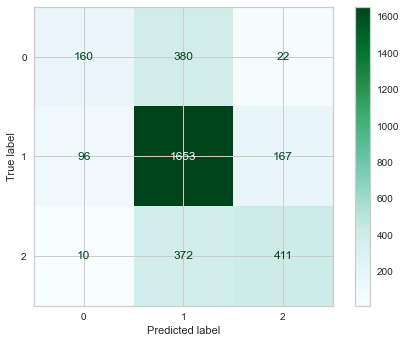

In [26]:
estimators = [('rf', RF),
              ('lgr', lgr),
              ('xgb', XGB)
             ]

# X_train, X_valtest, y_train, y_valtest = train_test_split(X_, Y_, train_size = 0.7, random_state = 30027)
# X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, train_size = 0.5, random_state = 30027)
stack_clf = StackingClassifier(estimators=estimators, final_estimator=SVM)
X_train = copy.deepcopy(X_train_)
X_val = copy.deepcopy(X_val_)
X_test = copy.deepcopy(X_test_)
X2 = SelectKBest(chi2, k=int(X_train.shape[1]*0.25)+8000)
X2.fit(X_train, y_train)
X_train = X2.transform(X_train)
X_val = X2.transform(X_val)
X_test = X2.transform(X_test)
t0 = time.time()
stack_clf.fit(X_train, y_train)
t1 = time.time() - t0

Train = pd.read_csv('./Data/Train_Preprocessed.csv')

kf = KFold(n_splits=5, shuffle=True, random_state=30027)
TrainWords = Train.copy(deep=True)
TrainWords['text'] = cleanAndSplit(Train, 'Hashtag')
train_acc_score = []
val_acc_score = []
test_acc_score = []
for train_index, valtest_index in kf.split(Train):
    val_index, test_index = train_test_split(valtest_index, train_size = 0.5, random_state = 30027)
    
    tmp_y_train = Train['sentiment'][train_index] 
    tmp_y_val = Train['sentiment'][val_index]
    tmp_y_test = Train['sentiment'][test_index]
    
    tmp_train = TrainWords.loc[train_index]
    tmp_val = TrainWords.loc[val_index]
    tmp_test = TrainWords.loc[test_index]
    
    TrainPreproTFIDF = tmp_train.copy(deep = True)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(stem_text)
    TrainPreproTFIDF['text'] = TrainPreproTFIDF['text'].apply(join_string)
    tfidf_vectorizer_Prepro = TfidfVectorizer(lowercase=False, ngram_range=(1,1))
    tmp_train = tfidf_vectorizer_Prepro.fit_transform(TrainPreproTFIDF['text'])


    ValPreproTFIDF = tmp_val.copy(deep = True)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(stem_text)
    ValPreproTFIDF['text'] = ValPreproTFIDF['text'].apply(join_string)
    tmp_val = tfidf_vectorizer_Prepro.transform(ValPreproTFIDF['text'])

    TestPreproTFIDF = tmp_test.copy(deep = True)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(stem_text)
    TestPreproTFIDF['text'] = TestPreproTFIDF['text'].apply(join_string)
    tmp_test = tfidf_vectorizer_Prepro.transform(TestPreproTFIDF['text'])
    
    stack_clf1 = StackingClassifier(estimators=estimators, final_estimator=SVM)
    
    X2_ = SelectKBest(chi2, k=int(X_train.shape[1]*0.25))
    X2_.fit(tmp_train, tmp_y_train)
    tmp_train = X2_.transform(tmp_train)
    tmp_val = X2_.transform(tmp_val)
    tmp_test = X2_.transform(tmp_test)
    
    stack_clf1.fit(tmp_train, tmp_y_train)

    train_acc_score.append(accuracy_score(tmp_y_train, stack_clf1.predict(tmp_train)))
    val_acc_score.append(accuracy_score(tmp_y_val, stack_clf1.predict(tmp_val)))
    test_acc_score.append(accuracy_score(tmp_y_test, stack_clf1.predict(tmp_test)))

print('training accuracy: ', sum(train_acc_score)/5)
print('validation accuracy: ', sum(val_acc_score)/5)
print('testing accuracy: ', sum(test_acc_score)/5)

print(f"fitting time is {t1}s")

stack_predofval = stack_clf.predict(X_val)
weighted_precision = precision_score(y_val, stack_predofval, average = "weighted")
weighted_recall= recall_score(y_val, stack_predofval, average = "weighted")
weighted_f1 = f1_score(y_val, stack_predofval, average = "weighted")
print("weighted precision is", weighted_precision)
print("weighted recall is", weighted_recall)
print("weighted f1_score is", weighted_f1)

# stack_clf_train_acc = np.mean(cross_val_score(stack_clf, X_train, y_train, cv=3))
# print("training accuracy is", stack_clf_train_acc)


# stack_clf_val_acc = np.mean(cross_val_score(stack_clf, X_val, y_val, cv=3))
# print("validation accuracy is", stack_clf_val_acc)


# stack_clf_test_acc = np.mean(cross_val_score(stack_clf, X_test, y_test, cv=3))
# print("testing accuracy is", stack_clf_test_acc)

plot_confusion_matrix(stack_clf, X_test, y_test, cmap = 'BuGn')

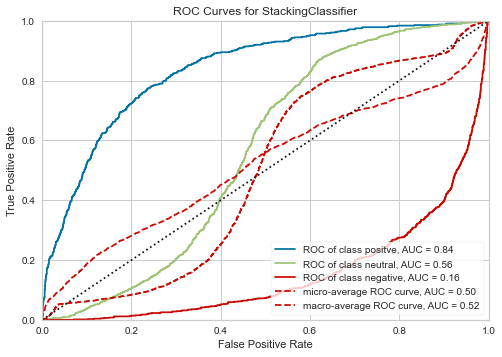

<AxesSubplot:title={'center':'ROC Curves for StackingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
visualizerSTACK = ROCAUC(stack_clf, classes=["positve", "neutral", "negative"])

# Fitting to the training data first then scoring with the test data                                    
visualizerSTACK.fit(X_train, y_train)
visualizerSTACK.score(X_test, y_test)
visualizerSTACK.show()

In [28]:
X_Future = copy.deepcopy(X_Future_)
X_Future = X2.transform(X_Future)
stack_pred = stack_clf.predict(X_Future)
tmp = pd.DataFrame({'tmp': stack_pred})

In [29]:
stack_pred = tmp['tmp'].replace([0, 1, 2], ['negative', 'neutral', 'positive'])

In [30]:
Stack_out = copy.deepcopy(Future)
Stack_out = Stack_out.drop(['text'], axis = 1)
Stack_out['sentiment'] = stack_pred

Stack_out.to_csv('./Predictions/Stack.csv', index = False)